# 结合抛物方程分裂步进思想的声场物理信息神经网络  
通过网络学习近似垂直声压分布，也就是算子X的计算。 
达成的效果是输入网格左边的声压和网格右边的声速可以得到网格右边的声压。 

## 非齐次Helmholtz方程的[r,z]二维情况  
首先对于非声源点可以把非齐次Helmholtz方程的声场视为无源场。
$$p_{xx}+p_{yy}+k^2p=0$$  
*进行抛物近似，对于环境随距离缓慢变化环境，仅考虑扩散波，方程化简为：*  
$$\frac{\partial P}{\partial r}=ik_0\sqrt{1+\mathtt{X}}P$$  
这个方程是常微分方程ODE，解为：  
$$P(r+\Delta r)=e^{ik_0\Delta r\sqrt{1+\mathtt{X}}}P(r)$$  
**其中：** 
>$\mathtt{X}=k_0^{-2}(\rho \frac{\partial}{\partial z} \frac{1}{\rho}\frac{\partial P}{\partial z}+k^2-k_0^2)$为算子   
>$k=\frac{\omega}{c(z)}$ 表示波数  
>$k_0=\frac{\omega}{c_0}$为参考波数  
>$c_0$为参考声速  

对于上面这种递推公式求解有不同的方法，Colins等采用pade近似和傅立叶级数方法求解，计算结果开角和精度取决于选择的pade近似系数。距离上的声压计算并不困难，深度方向算子$\mathtt{X}$是计算的主要困难点。

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from sciann import Variable, Functional, Data, SciModel, PDE, Parameter
import tensorflow.keras.callbacks as callbacks
from sciann.utils.math import diff, cos, sqrt, sin
import scipy.io                                                                                                                         
import os
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


## 数据集设置：

采用抛物方程计算程序RAM作为数据来源，对Collins给出的示例算例数据进行处理:  
>1.提取声压实部和声压虚部;  
>2.按照网格左右对应a侧和b侧.

In [2]:
def data_tmp(num=10000, random=True):
    # load data
    data = scipy.io.loadmat('Data/slit_cylinder_pre_c0_w0.mat')
    Re_Pa_star = data['RePa_star'][:, :]  # R-1 x Z
    Im_Pa_star = data['ImPa_star'][:, :]  # R-1 x Z
    Re_Pb_star = data['RePb_star'][:, :]  # R-1 x Z
    Im_Pb_star = data['ImPb_star'][:, :]  # R-1 x Z
    Rhoa_star = data['rhoa_star'][:, :]   # R-1 x Z
    Rhob_star = data['rhob_star'][:, :]   # R-1 x Z
    ca_star = data['ca_star'][:, :]       # R-1 x Z
    cb_star = data['cb_star'][:, :]       # R-1 x Z
    omega = data['omega_star'][:, :]      # R-1 x Z
    # grids Range and Depth
    R = data['R'][:, :]  # R x 1
    Z = data['Z']  # Z x 1
    # grids number of range&depth
    nr = R.shape[1] - 1
    nz = Z.shape[1]
    Z_star = np.repeat(Z[:, 0:].T, nr, axis=1)
    PI = 3.1415926
    ka_star = omega[0][0] / ca_star  # R-1 x Z
    kb_star = omega[0][0] / cb_star  # R-1 x Z
    # Pick random data
    if random:
        idx = np.random.choice((nr)*(nz), num, replace=False)
    else:
        idx = np.arange(0, (nr)*(nz))
        nr, nz = np.meshgrid(R[:,1:], Z)

    zz = Z_star.flatten()[idx, None]  # (R-1)*(Z-2) x 1
    ka = ka_star.flatten()[idx, None]  # (R-1)*(Z-2) x 1
    rha = Rhoa_star.flatten()[idx, None]  # (R-1)*(Z-2) x 1
    Rpa = Re_Pa_star.flatten()[idx, None]  # (R-1)*(Z-2) x 1
    Ipa = Im_Pa_star.flatten()[idx, None]  # (R-1)*(Z-2) x 1

    kb = kb_star.flatten()[idx, None]  # (R-1)*(Z-2)  x 1
    rhb = Rhob_star.flatten()[idx, None]  # (R-1)*(Z-2)  x 1
    Rpb = Re_Pb_star.flatten()[idx, None]  # (R-1)*(Z-2)  x 1
    Ipb = Im_Pb_star.flatten()[idx, None]  # (R-1)*(Z-2)  x 1
    # rloss = np.tile(10 * np.log10(R_star + eps), (Z, 1)).T
    # tl = -20 * np.log10(eps + np.sqrt(Re_P_star ** 2 + Im_P_star ** 2)) + rloss
    return zz, ka, kb, Rpa, Ipa, Rpb, Ipb, nr, nz

## 主函数:  
>设定变量Variable、参数Parameter和函数Function  
>确定网络输入量和对应数据  
>确定网络约束和对应数据  
>设置好激活函数、寻优方法、损失函数、自适应方法，开始训练

In [ ]:
if __name__ == "__main__":
    # prepare data
    z_train, ka_train, kb_train, pa_real_train, pa_imag_train, pb_real_train, pb_imag_train, nr, nz = data_tmp()
#     # flag
    IsTrain = False
#     IsTrain = True

    # Variables and Fields
    z = Variable("z", dtype='float64')
    k = Variable("k", dtype='float64')
    pa_real = Variable("pa_real", dtype='float64')
    pa_imag = Variable("pa_imag", dtype='float64')
#     k0 = Parameter(150.0*3.141592653/1500.0, inputs=[z, k], name='k0')
    k0 = Parameter(np.random.rand(), inputs=[z, k], name='k0')
    dr = Parameter(np.random.rand(), inputs=[z, k], name='dr')
    # layers = [256, 256, 128, 128, 64, 64, 32, 32, 16, 16, 8, 8]
    # layers = 10*[50]
    layers = 4*[60]
    pb_real = Functional("pb_real", [z, k, pa_real], layers, 'tanh', res_net=True)
    pb_imag = Functional("pb_imag", [z, k, pa_imag], layers, 'tanh', res_net=True)

    # Define constraints, pde split into real- and complex-valued part.
    d1 = Data(pb_real)
    d2 = Data(pb_imag)
    X_real = sqrt(diff(pb_real, z, order=2) + k**2 + k0**2)
    X_imag = sqrt(diff(pb_imag, z, order=2) + k**2 + k0**2)
    c1 = PDE(pb_real - cos(dr*X_real)*pa_real)
    c2 = PDE(pb_imag - sin(dr*X_imag)*pa_imag)

    data_d1 = pb_real_train
    data_d2 = pb_imag_train
    data_c1 = 'zeros'
    data_c2 = 'zeros'

    input = [z, k, pa_real, pa_imag]
    input_data = [z_train, ka_train, pa_real_train, pa_imag_train]
    # constraints
    cons = [d1, d2, c1, c2]
    cons_data = [data_d1, data_d2, data_c1, data_c2]

    model = SciModel(
        input,
        cons,
        loss_func="mse",
        optimizer='Adam'
        )

    # callbacks
    current_path = os.path.abspath('')
    checkpoint_filepath = str(os.path.join(current_path, 'callbacks/helmholtz/slit_ram_dr10_dz2.ckpt'))
    save_path = str(os.path.join(current_path, 'model/tanh_mse_Adam_NTK_4x60.hdf5'))
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='auto',
        save_best_only=True,
        learning_rate=1e-6
    )
    if IsTrain:
        t = time.time()
        history = model.train(
            input_data,
            cons_data,
            epochs=200,
            batch_size=100,
            adaptive_weights={"method":'NTK', 'freq':100, 'use_score':True},
            shuffle=True,
            learning_rate=0.001,
            reduce_lr_after=100,
            stop_loss_value=1e-8
#             callbacks=[model_checkpoint_callback]
        )
        t = time.time() - t
        model.save_weights(save_path)

        fig1 = plt.figure(1)
        plt.semilogy(history.history['loss'])
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.savefig('./figures/fig5_loss_history.png')

    else:
        model.load_weights(save_path)
    

*采用tanh激活函数、MSE损失函数和NTK权重自适应*  
从损失曲线看，在**epochs=66**已经收敛到较好的结果。  
其中：  
- Total samples: **10000** 
- Batch size: **100** 
- Total batches: **100** 

  ## 绘制RAM结果和网络预测结果

In [ ]:
    print("k0-exact: {}, k0-pred: {}".format(150.0*3.141592653/1500.0, k0.value)) 
    # eval data
    z_train, ka_train, kb_train, pa_real_train, pa_imag_train, pb_real_train, pb_imag_train, nr, nz = data_tmp(random=False)
    
    # exact solution
    RePb_exact = pb_real_train.reshape(199, -1)
    ImPb_exact = pb_imag_train.reshape(199, -1)
    rloss = 10 * np.log10(nr)
    TL = -20 * np.log10(np.sqrt(RePb_exact ** 2 + ImPb_exact ** 2)) + rloss
    fig = plt.figure(1)
    gs0 = gridspec.GridSpec(1, 4)
    gs0.update(top=1 - 0.1, bottom=0.15, left=0.12, right=1.9, wspace=0.6)
    ax = plt.subplot(gs0[:, 0:2])
    h = ax.pcolormesh(nr / 1000, nz, TL, cmap='jet_r', shading='nearest', vmin=40, vmax=120)
    ax.invert_yaxis()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(h, cax=cax)
    ax.set_xlabel('$Range,km$')
    ax.set_ylabel('$Depth,m$')
    ax.set_title('Exact Transmission Loss', fontsize=12)
    
    # pred solution
    eval_input = [z_train, ka_train, pa_real_train, pa_imag_train]
    p_real_pred = pb_real.eval(model, eval_input).reshape(199, -1)
    p_imag_pred = pb_imag.eval(model, eval_input).reshape(199, -1)
    tl_pred = -20 * np.log10(np.sqrt(p_real_pred ** 2 + p_imag_pred ** 2)) + rloss
    ax = plt.subplot(gs0[:, 2:4])
    h = ax.pcolormesh(nr / 1000, nz, tl_pred, cmap='jet_r', shading='nearest', vmin=40, vmax=120)
    ax.invert_yaxis()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(h, cax=cax)
    ax.set_xlabel('$Range,km$', fontsize=12)
    ax.set_ylabel('$Depth,m$', fontsize=12)
    ax.set_title('Learned Transmission Loss', fontsize=13)
    # save
    plt.savefig('./figures/fig5-1.png', dpi=300, bbox_inches = 'tight')

   ## 绘制给定深度声压传播损失比较结果

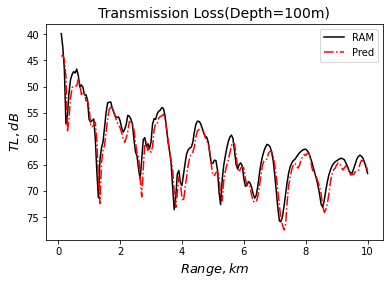

In [9]:
    fig = plt.figure(2)
    # Num of Depth, with dz=2m
    d = 50
    gs0 = gridspec.GridSpec(1, 3)
    gs0.update(top=1 - 0.1, bottom=0.15, left=0.12, right=0.9, wspace=0.6)
    ax = plt.subplot(gs0[:, :])
    h = ax.plot(nr[d, :] / 1000,TL[d, :], 'k-',linewidth=1.5, label='Exact Pressure')
    # pred solution
    h = ax.plot(nr[d, :] / 1000, tl_pred[d, :], 'r-.', linewidth=1.5, label='Learned Pressure')
    ax.invert_yaxis()
    ax.set_xlabel('$Range,km$',fontsize=13)
    ax.set_ylabel('$TL,dB$',fontsize=13)
    ax.set_title(('Transmission Loss'+'(Depth='+str(d*2)+'m)'), fontsize=14)
    plt.legend()
    plt.savefig('./figures/fig5-2.png', dpi=300, bbox_inches = 'tight')